## Stable Diffusion classic fine tuning example(multi-gpu training) 
> aka native text2image training for whole model
* Classtic fine tuning used [Linaqruf's hitokomoru dataset](https://huggingface.co/datasets/Linaqruf/locon-dataset/tree/main), total 98 pictures (regarding how to prepare such dataset, check [content from kohya-ss github](https://github.com/kohya-ss/sd-scripts/blob/main/train_README-ja.md#%E3%83%A1%E3%82%BF%E3%83%87%E3%83%BC%E3%82%BF%E3%83%95%E3%82%A1%E3%82%A4%E3%83%AB%E3%81%AE%E4%BD%9C%E6%88%90))
* Base model is [JosephusCheung/ACertainty](https://huggingface.co/JosephusCheung/ACertainty) for better animation effect, you can also try sd1.5
* Training method also refered to the descripton of [Linaqruf/hitokomoru-diffusion-v2](https://huggingface.co/Linaqruf/hitokomoru-diffusion-v2)
* Training scripts used [fine_tune.py from kohya-ss/sd-scripts](https://github.com/kohya-ss/sd-scripts/blob/main/fine_tune_README_ja.md), images were processed use [Aspect Ratio Bucketing](https://github.com/kohya-ss/sd-scripts/blob/main/train_README-ja.md#aspect-ratio-bucketing)
* Since kohya-ss/sd-scripts now supported multi-gpu training by leveraging [Accelerate's --multi_gpu feature](https://huggingface.co/docs/accelerate/package_reference/cli#accelerate-launch), the example used it
* Tested with ml.g5.12xlarge SageMaker notebook instance, which provides 4 NVIDIA A10G GPUs for parallelized(distributed) training


## 1. Install dependencies

In [ ]:
!pip install torch==2.0.0+cu118 torchvision==0.15.1+cu118 --extra-index-url https://download.pytorch.org/whl/cu118
!pip install xformers==0.0.18
!pip install wandb dadaptation lion-pytorch

In [ ]:
!git clone https://github.com/kohya-ss/sd-scripts
%cd sd-scripts/
!pip install -U -r requirements.txt
!pip install natsort

In [ ]:
# fix some warnings and bugs poping up from sagemaker notebook

!pip install tensorflow==2.11.0
!sudo rm -rf /lib64/libstdc++.so.6 /lib64/libstdc++.so.6
!sudo ln -s /home/ec2-user/anaconda3/envs/python3/lib/libstdc++.so.6 /lib64/libstdc++.so.6

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

## 2. Initialize training environment 

In [ ]:
from accelerate.utils import write_basic_config
write_basic_config()

Refer "dataset-example.toml" to configure your own .toml file

In [ ]:
%%writefile dataset.toml
[general]
enable_bucket = true
shuffle_caption = true
keep_tokens = 0
# color_aug = true

# DreamBooth caption based style datasets
[[datasets]]
resolution = 768
batch_size = 4
max_bucket_reso = 1280

  [[datasets.subsets]]
  image_dir = './images/hitokomoru'
  metadata_file = './images/hitokomoru/meta_clean.json'

In [ ]:
%%writefile sample_prompts.txt
# prompt 1
1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress, jewelry, make-up, luxury, upper body, masterpiece, best quality, highly detailed --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), text, logo, watermark --w 512 --h 768 --d 3129467234 --l 7.5 --s 20

# # prompt 2
# 1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress, jewelry, make-up, luxury, upper body, masterpiece, best quality, highly detailed --n lowres, worst quality, ugly, extra limbs, deformed legs, disfigured legs, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), text, logo, watermark --w 512 --h 768 --d 3129467235 --l 7.5 --s 20


In [7]:
MODEL_NAME = "JosephusCheung/ACertainty"
DATASET_CONFIG = "./dataset.toml"
TRAIN_DATA_DIR = "./images/hitokomoru"
IMAGES_OUTPTS = "./images/outputs"
MODEL_OUTPTS = "./output"

!mkdir -p $TRAIN_DATA_DIR $IMAGES_OUTPTS $MODEL_OUTPTS

## 3. Prepare training dataset

### 3.1 Download image dataset and organize image files

In [ ]:
!wget https://huggingface.co/datasets/Linaqruf/locon-dataset/resolve/main/hitokomoru_locon_dataset.zip

In [9]:
import os
import shutil
import zipfile

zip_file = 'hitokomoru_locon_dataset.zip'
target_dir = TRAIN_DATA_DIR
temp_dir = target_dir+'/temp'

with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall(temp_dir)

bottom_dir = None
for root, dirs, files in os.walk(temp_dir):
    if not dirs:
        if bottom_dir is None:
            bottom_dir = root
        elif len(root.split(os.sep)) > len(bottom_dir.split(os.sep)):
            bottom_dir = root
        
for root, dirs, files in os.walk(bottom_dir):
    for file in files:
        if not file.endswith('.npz'):
            source_file = os.path.join(root, file)
            target_file = os.path.join(target_dir, file)
            shutil.copy(source_file, target_file)
    
shutil.rmtree(temp_dir)
os.remove('./hitokomoru_locon_dataset.zip')

### 3.2 Prepare classic fine tuning necessary [metadata file](https://github.com/kohya-ss/sd-scripts/blob/main/train_README-ja.md#%E3%82%AD%E3%83%A3%E3%83%97%E3%82%B7%E3%83%A7%E3%83%B3%E3%81%A8%E3%82%BF%E3%82%B0%E6%83%85%E5%A0%B1%E3%81%AE%E5%89%8D%E5%87%A6%E7%90%86)

In [ ]:
!python ./finetune/merge_captions_to_metadata.py --full_path $TRAIN_DATA_DIR $TRAIN_DATA_DIR/meta_cap.json

In [ ]:
!python ./finetune/merge_dd_tags_to_metadata.py --full_path $TRAIN_DATA_DIR --in_json $TRAIN_DATA_DIR/meta_cap.json $TRAIN_DATA_DIR/meta_cap_dd.json

In [ ]:
!python ./finetune/clean_captions_and_tags.py $TRAIN_DATA_DIR/meta_cap_dd.json $TRAIN_DATA_DIR/meta_clean.json

## 3. Train model
* Enable multi GPU training, you can disable by removing "--multi_gpu" flag  
* Refer to [train_util.py](https://github.com/kohya-ss/sd-scripts/blob/main/library/train_util.py) for all of configurations you can change

In [ ]:
!accelerate launch --multi_gpu fine_tune.py \
   --pretrained_model_name_or_path=$MODEL_NAME \
   --output_dir=$MODEL_OUTPTS \
   --output_name="classic_finetune_hitokomoru_ACertainty" \
   --dataset_config=$DATASET_CONFIG \
   --learning_rate=2e-6 --max_train_steps=5000 \
   --clip_skip=2 \
   --max_token_length=225 \
   --save_every_n_steps=500 \
   --xformers --optimizer_type="AdamW8bit" --gradient_checkpointing \
   --mixed_precision="fp16" \
   --cache_latents_to_disk \
   --sample_every_n_steps=500 \
   --sample_prompts="./sample_prompts.txt" \
   --sample_sampler="euler_a" \
   --logging_dir="./logs" \
   --log_with="all" \
   --log_tracker_name="classic_finetune_hitokomoru_ACertainty" \
   --wandb_api_key="45983308f36536fe9bd4afd336edde8ce15730fe" # register a user via https://wandb.ai and get an API key
   # --cache_latents \
   # --save_model_as="safetensors" \

## 4. Mode inference testing

In [ ]:
from natsort import natsorted
from glob import glob
import os

WEIGHTS_DIR = natsorted(glob(MODEL_OUTPTS + os.sep + "*"))[0]

print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")    

  0%|          | 0/20 [00:00<?, ?it/s]

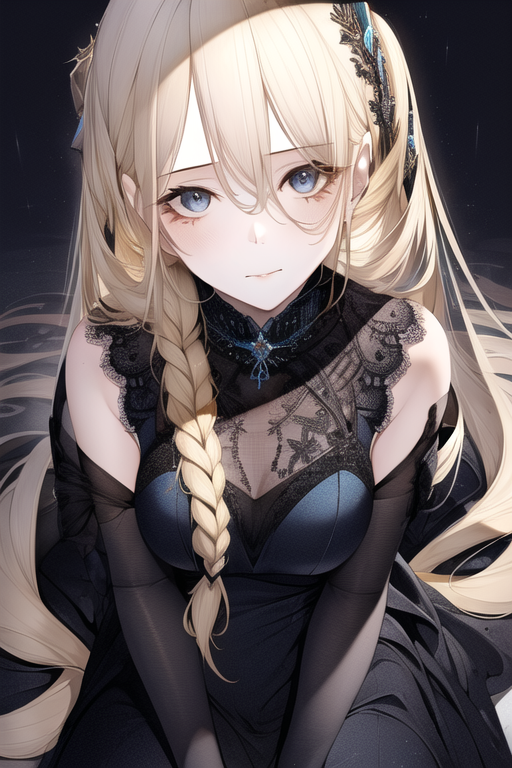

./images/outputs/462602318589314_2023-05-06 11:44:35.png



  0%|          | 0/20 [00:00<?, ?it/s]

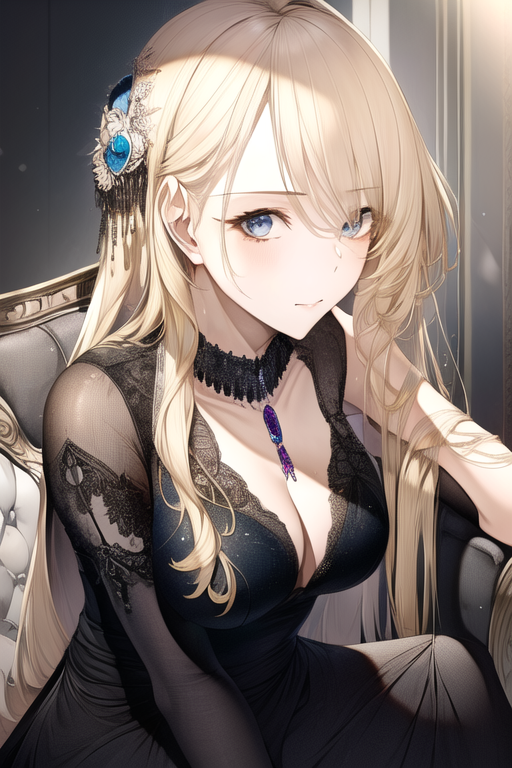

./images/outputs/7135817133047478_2023-05-06 11:44:38.png


Seeds for generating images: [462602318589314, 7135817133047478]



In [16]:
import torch
import datetime

from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler, DPMSolverMultistepScheduler
model_dir = WEIGHTS_DIR

scheduler = EulerAncestralDiscreteScheduler.from_pretrained(model_dir, subfolder="scheduler")
generator = torch.Generator(device="cuda")
pipe = StableDiffusionPipeline.from_pretrained(model_dir, scheduler=scheduler, torch_dtype=torch.float16)

pipe = pipe.to("cuda")
prompt = "1girl, solo, sitting, confident expression, long blonde hair, blue eyes, formal dress, jewelry, make-up, luxury, upper body, masterpiece, best quality, highly detailed"
negative_prompt = "lowres, worst quality, ugly, (disfigured), ((mutated hands, misshapen hands, mutated fingers, fused fingers):1.2), extra limbs, deformed legs, disfigured legs, text, logo, watermark"

num_images = 2
seeds = []
for _ in range(num_images):
    seed = generator.seed()
    seeds.append(seed)
    generator = generator.manual_seed(seed)
    image = pipe(
        prompt=prompt,
        negative_prompt=negative_prompt,
        height=768,
        width=512,
        num_images_per_prompt=1,
        num_inference_steps=20,
        guidance_scale=7.5,
        generator = generator
    ).images[0]
    display(image)
    now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    file_path = IMAGES_OUTPTS + "/" + str(seed) + "_" + str(now) + ".png"
    print(file_path + "\n")
    image.save(file_path)
    
# print(seeds)
print(f"\nSeeds for generating images: {seeds}\n")


  0%|          | 0/20 [00:00<?, ?it/s]

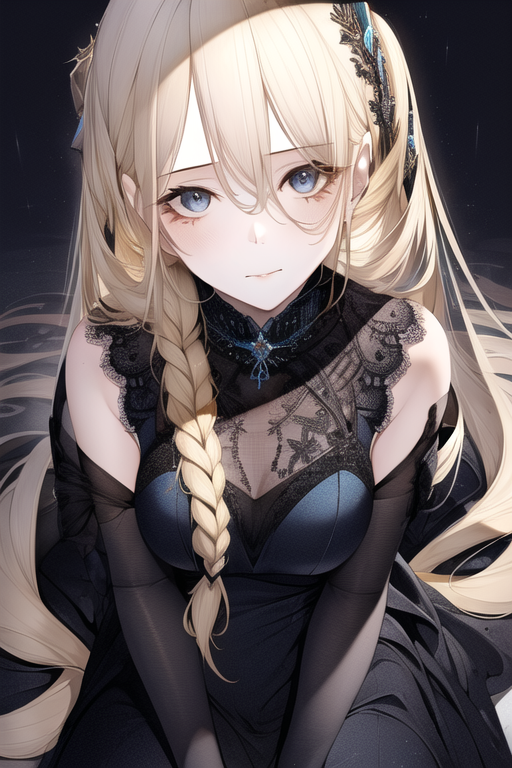

In [17]:
# Comment below codes, if you don't want to produce the same images again
seed = seeds[0] # use the first seed
generator.manual_seed(seed)
image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    height=768,
    width=512,
    num_images_per_prompt=1,
    num_inference_steps=20,
    guidance_scale=7.5,
    generator = generator
).images[0]
display(image)

In [ ]:
# Comment below codes out, if you don't want to generate ckpt file for web UI

!wget -q https://raw.githubusercontent.com/huggingface/diffusers/main/scripts/convert_diffusers_to_original_stable_diffusion.py
ckpt_path = WEIGHTS_DIR + "/model.safetensors"
half_arg = ""
# Whether to convert to fp16, takes half the space (2GB).
fp16 = True # {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg --use_safetensors
print(f"[*] Converted ckpt saved at {ckpt_path}")